In [1]:
# Load dependencies
# Data processing
import pandas as pd

# Parallel processing
import swifter
import numpy as np
from multiprocessing import Pool

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt

# Misc
import json # JSON manipulation
import tldextract # Extract tlds
import idna # Punycode conversions
import re # Registry modifications
from datetime import datetime # Date calculations

from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests

# OUTPUT--------------

print("Successful.")

Successful.


In [2]:
# LOAD--------------------

# icann.csv
icann_df = pd.read_csv("data/icann.csv")

# Create tld-type dictionary
tld_type = pd.Series(icann_df.type.values, index=icann_df.tld).to_dict()

# registrar.csv
registrar_df = pd.read_csv("data/registrar.csv")

# Create registrar-id dictionary
registrar = pd.Series(registrar_df.registrar.values, index=registrar_df.id).to_dict()

# LOAD--------------------

# all_types_domain_balanced.json
df = pd.read_json("data/all_types_domains_balanced.json", orient="records", lines=True)

# Print beginning data
print(f"\nDomains - {len(df)} starting rows")

# Print # of null entries
before = len(df)
df = df[df["domain"].notnull()]
after = len(df)
print(f"Domains - nulls dropped: {(before - after)}")

# Print # of duplicates
before = len(df)
df = df.drop_duplicates(subset=["domain"])
after = len(df)
print(f"Domains - duplicates dropped: {(before - after)}")

# Print null entries
# df = df[df["domain"].isnull()]
# print(null_entries)
# df = df[df["domain"].notnull()]

# Print duplicates
# duplicates = df[df.duplicated(subset=["domain"], keep=False)]
# print(duplicates)
# df = df.drop_duplicates(subset=["domain"])

# Print ending data
print(f"Domains - {len(df)} ending rows")

# LOAD--------------------

# all_types_domains_balanced_registered_domains_whois_parsed.json
# TODO: Uncomment duplicates after I figure out how to deal with them

whois_df = pd.read_json("data/all_types_domains_balanced_registered_domains_whois_parsed_correct_registrar_names_deduplicated_ids.json", orient="records", lines=True)

# Print beginning data
print(f"\nWhois - {len(whois_df)} starting rows")

# Print # of null entries
before = len(whois_df)
whois_df = whois_df[whois_df["domain"].notnull()]
after = len(whois_df)
print(f"Whois - domain nulls dropped: {(before - after)}")

# Print # of duplicates
before = len(whois_df)
whois_df = whois_df.drop_duplicates(subset=["domain"])
after = len(whois_df)
print(f"Whois - duplicates dropped: {(before - after)}")

# Print # of malformed registrar ids
before = len(whois_df)
whois_df = whois_df[whois_df["registrar_id"].notnull()]
after = len(whois_df)
print(f"Whois - registrar nulls dropped: {(before - after)}")

# Print null entries
# null_entries = whois_df[whois_df["domain"].isnull()]
# print(null_entries)
# whois_df = whois_df[whois_df["domain"].notnull()]

# Print duplicates
# duplicates = whois_df[whois_df.duplicated(subset=["domain"], keep=False)]
# print(duplicates)
# whois_df = whois_df.drop_duplicates(subset=["domain"])

# Print ending data
print(f"Whois - {len(whois_df)} ending rows")

# LOAD--------------------

# tld-list-history-2023-11-01.json
tld_list_df = pd.read_csv("data/fixed-tld-list-daily-combined.csv")

# Print beginning data
print(f"\nTLD list - {len(tld_list_df)} starting rows")

# Print unique registrar count
print(f"TLD List - {tld_list_df['registrar'].nunique()} starting unique registrars")

# tld-list-match-registrar-by-id.csv
registrar_df = pd.read_csv("data/tld-list-match-registrar-by-id.csv")

# Print # of unmatched entries
before = len(tld_list_df)
tld_list_merged_df = tld_list_df.merge(registrar_df, on='registrar', how='inner')
after = len(tld_list_merged_df)
print(f"TLD List - unmatched registrars dropped: {(before - after)}")

# Print # of unaccredited entires
before = len(tld_list_merged_df)
tld_list_merged_df = tld_list_merged_df[tld_list_merged_df['registrar_id'] != 0]
after = len(tld_list_merged_df)
print(f"TLD List - unaccredited registrars dropped: {(before - after)}")

# Print # of not register data
before = len(tld_list_merged_df)
tld_list_merged_df = tld_list_merged_df[tld_list_merged_df["price-type"] == "register"]
after = len(tld_list_merged_df)
print(f"TLD List - non-register price type dropped: {(before - after)}")

# Print ending data
print(f"TLD list - {len(tld_list_merged_df)} ending rows")

# Print unique registrar count
print(f"TLD List - {tld_list_merged_df['registrar'].nunique()} ending unique registrars")

# OUTPUT--------------

# Save filtered tld_list to file
# tld_list_merged_df.to_csv("data/filtered-tld-list-by-registrar-and-price-type.csv", index=False)

print("\nSuccessful.")


Domains - 24528 starting rows
Domains - nulls dropped: 0
Domains - duplicates dropped: 99
Domains - 24429 ending rows

Whois - 216074 starting rows
Whois - domain nulls dropped: 0
Whois - duplicates dropped: 196358
Whois - registrar nulls dropped: 0
Whois - 19716 ending rows

TLD list - 84269869 starting rows
TLD List - 64 starting unique registrars
TLD List - unmatched registrars dropped: 0
TLD List - unaccredited registrars dropped: 22349286
TLD List - non-register price type dropped: 41715128
TLD list - 20205455 ending rows
TLD List - 42 ending unique registrars

Successful.


In [6]:
pivot_df = tld_list_df.pivot_table(index=['tld', 'registrar'], columns='price-type', values='price')

# Calculate price differences for renewal and transfer compared to register
pivot_df['renewal_diff_pct'] = (pivot_df['renewal'] - pivot_df['register']) / pivot_df['register'] * 100
pivot_df['transfer_diff_pct'] = (pivot_df['transfer'] - pivot_df['register']) / pivot_df['register'] * 100

# Calculate average percentage differences for each TLD
avg_pct_diff_df = pivot_df.groupby('tld')[['renewal_diff_pct', 'transfer_diff_pct']].mean()

# Calculate overall average percentage differences
avg_renewal_diff_pct = avg_pct_diff_df['renewal_diff_pct'].mean()
avg_transfer_diff_pct = avg_pct_diff_df['transfer_diff_pct'].mean()

# Print the overall average percentage differences
print(f"Transfer rates are on average {avg_transfer_diff_pct:.2f}% more expensive than register rates.")
print(f"Renewal rates are on average {avg_renewal_diff_pct:.2f}% more expensive than register rates.")

Transfer rates are on average 19.48% more expensive than register rates.
Renewal rates are on average 26.92% more expensive than register rates.


In [4]:
# Extract TLDs and get the TLD type on dataframes

# APPLY--------------------

# all_types_domain_balanced.json
df["tld"] = df["domain"].swifter.apply(lambda x: tldextract.extract(x).suffix)
df["tld_type"] = df["tld"].swifter.apply(lambda x: tld_type.get(x, 'unknown'))

# APPLY--------------------

# all_types_domains_balanced_registered_domains_whois_parsed.json
# TLD Type
whois_df["tld"] = whois_df["domain"].swifter.apply(lambda x: tldextract.extract(x).suffix)
whois_df["tld_type"] = whois_df["tld"].swifter.apply(lambda x: tld_type.get(x, 'unknown'))

# Registrar
allowed_values = [9994, 9995, 9996, 9997, 9998, 9999, 10007, 10009, 4000001, 8888888]

whois_df['registrar_id'] = whois_df['registrar_id'].astype(int)

before = len(whois_df)
whois_df = whois_df[
    (whois_df['registrar_id'].isin(allowed_values)) |
    ((whois_df['registrar_id'] >= 57) & (whois_df['registrar_id'] <= 4325))
]
after = len(whois_df)
print(f"Whois - misconfigured registrar ids dropped: {(before - after)}")

whois_df["registrar"] = whois_df["registrar_id"].swifter.apply(lambda x: registrar.get(x, 'unknown'))

# APPLY--------------------

# Convert to punycode
# tld-list-history-2023-11-01.json
tld_list_merged_df['tld'] = tld_list_merged_df['tld'].swifter.apply(lambda x: idna.encode(x).decode('utf-8') if any(ord(char) > 127 for char in x) else x)
tld_list_merged_df = tld_list_merged_df.sort_values(by='tld', ascending=True)

# OUTPUT--------------

print("\nSuccessful.")

Pandas Apply:   0%|          | 0/24429 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24429 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19716 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19716 [00:00<?, ?it/s]

Whois - misconfigured registrar ids dropped: 826


Pandas Apply:   0%|          | 0/18890 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20205455 [00:00<?, ?it/s]


Successful.


In [5]:
# Set up to add price data to whois_df from tld_list_df
# TODO: figure out how to determine whether to use renewal, register, or transfer price

### FORMAT---------------------

# Print starting data
print(f"Whois - {len(whois_df)} starting rows")
print(f"TLD list - {len(tld_list_merged_df)} starting rows")

# Print starting registrars
print(f"Whois - {whois_df['registrar'].nunique()} starting unique registrars")

# Drop null dates whois
before = len(whois_df)
whois_price = whois_df[whois_df["created"].notnull()].copy()
after = len(whois_price)
print(f"Whois - null dates dropped: {(before - after)}")

# Drop null dates tld list
before = len(tld_list_merged_df)
tld_list_price = tld_list_merged_df[tld_list_merged_df["date"].notnull()].copy()
after = len(tld_list_price)
print(f"TLD list - null dates dropped: {(before - after)}")

# Format dates
whois_price["created"] = pd.to_datetime(whois_price["created"], format="%Y-%m-%d", errors='coerce')
tld_list_price["date"] = pd.to_datetime(tld_list_price["date"], format="%Y-%m-%d", errors='coerce')

# Drop misconfigured dates whois
before = len(whois_price)
whois_price = whois_price[whois_price["created"].notna()]
after = len(whois_price)
print(f'Whois - misconfigured dates dropped: {(before - after)}')

# Drop misconfigured dates tld list
before = len(tld_list_price)
tld_list_price = tld_list_price[tld_list_price["date"].notna()]
after = len(tld_list_price)
print(f'TLD list - misconfigured dates dropped: {(before - after)}')

### FILTER--------------------

# Group data by tld
tld_list_price = tld_list_price.groupby("tld")

### FUNCTIONS--------------------

# Function to find the price closest to the created date with matching registrar_id
def find_closest_price(row):
    try:
        # Retrieve the tld group
        tld_group = tld_list_price.get_group(row["tld"])
    except KeyError:
        # If there is no group, return none
        return pd.Series([None, None, None], index=["price", "price-date", "price-registrar"])

    # Filter by matching registrar_id
    tld_group = tld_group[tld_group['registrar_id'] == row['registrar_id']]

    # Check if empty
    if tld_group.empty:
        return pd.Series([None, None, None], index=["price", "price-date", "price-registrar"])
    
    # Compute days difference and find the closest date
    tld_group['days-difference'] = (row['created'] - tld_group['date']).dt.days
    closest_date = tld_group[tld_group['days-difference'] >= 0].nsmallest(1, 'days-difference')
    
    # Check if empty
    if closest_date.empty:
        return pd.Series([None, None, None], index=["price", "price-date", "price-registrar"])

    # Concatenate the registrars (sadly not working rn)
    # registrars = ', '.join(set(closest_date['registrar']))
    return pd.Series([closest_date["price"].iloc[0], closest_date["date"].dt.date.iloc[0], closest_date["registrar"].iloc[0]], index=["price", "price-date", "price-registrar"])

# Function to split computation load among 10 cores
def apply_parallel(data, func):
    data_split = np.array_split(data, 10)
    with Pool(processes=10) as pool:
        data = pd.concat(pool.map(func, data_split))
    return data

# Function to run find_closest_price on each individualrow
def process_chunk(chunk):
    return chunk.apply(find_closest_price, axis=1)

# APPLY--------------------

# Apply function to the data frame
whois_price[["price", "price-date", "price-registrar"]] = apply_parallel(whois_price, process_chunk)

# FORMAT--------------------

# Make the none null dates human readable
whois_price["created"] = whois_price["created"].swifter.apply(lambda x: x.strftime("%Y-%m-%d") if pd.notnull(x) else x)
whois_price["price-date"] = whois_price["price-date"].swifter.apply(lambda x: x.strftime("%Y-%m-%d") if pd.notnull(x) else x)

# Drop null price, price-dates, and price-registrars
before = len(whois_price)
whois_price_filtered = whois_price.dropna(subset=["price", "price-date", "price-registrar"])
after = len(whois_price_filtered)
print(f'Whois - null price data dropped: {(before - after)}')

# Print ending data
print(f"Whois - {len(whois_price_filtered)} ending rows")
print(f"TLD list - {len(tld_list_price)} ending rows")

# Print ending registrars
print(f"Whois - {whois_price_filtered['registrar'].nunique()} ending unique registrars")

# OUTPUT--------------

# Save whois_data to whois-with-prices.json
whois_price_filtered.to_json("output/whois-full-with-prices.json", orient="records", lines=True)

print("\nSuccessful.")

Whois - 18890 starting rows
TLD list - 20205455 starting rows
Whois - 310 starting unique registrars
Whois - null dates dropped: 656
TLD list - null dates dropped: 0
Whois - misconfigured dates dropped: 104
TLD list - misconfigured dates dropped: 0


Pandas Apply:   0%|          | 0/18130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/18130 [00:00<?, ?it/s]

Whois - null price data dropped: 10333
Whois - 7797 ending rows
TLD list - 2718 ending rows
Whois - 35 ending unique registrars

Successful.


In [48]:
total_domains = whois_price_filtered['price'].count()

# Count the number of domains with a price under $20
under_20_domains = whois_price_filtered[whois_price_filtered['price'] <= 25]['price'].count()

# Calculate the percentage
percentage_under_20 = (under_20_domains / total_domains) * 100

# Display the result
print(f"Percentage of malicious domains purchased under $20: {percentage_under_20:.2f}%")

Percentage of malicious domains purchased under $20: 98.83%


In [40]:
total_tlds = whois_price['registrar'].value_counts().sum()

# Calculate top 10 TLDs with their counts
top_registrars = whois_price_filtere['registrar'].value_counts().head(10).reset_index()

# Rename columns for clarity
top_registrars.columns = ['Registrar', 'Count']

# Add a percentage column
top_registrars['Percentage'] = (top_registrars['Count'] / total_tlds) * 100

# Format percentage for better readability (optional)
top_registrars['Percentage'] = top_registrars['Percentage'].map('{:.2f}%'.format)

# Display the result as a plain-text table
print(top_registrars.to_string(index=False))

                                              Registrar  Count Percentage
                                        NameCheap, Inc.   5525     30.47%
                                       GoDaddy.com, LLC   1950     10.76%
                                          NameSilo, LLC   1393      7.68%
                PDR Ltd. d/b/a PublicDomainRegistry.com    882      4.86%
                                    Tucows Domains Inc.    800      4.41%
Alibaba Cloud Computing Ltd. d/b/a HiChina (www.net.cn)    616      3.40%
               NICENIC INTERNATIONAL GROUP CO., LIMITED    541      2.98%
                   Registrar of Domain Names REG.RU LLC    499      2.75%
                                            Dynadot Inc    436      2.40%
                                            Porkbun LLC    384      2.12%


In [43]:
com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'com']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'net']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'top']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'xyz']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'ru']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'org']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'online']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'one']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'info']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

com_prices = tld_list_merged_df[tld_list_merged_df['tld'] == 'cn']

# Sort by registrar and date for accurate processing
com_prices = com_prices.sort_values(by=['registrar', 'date'])

# Calculate the duration each price was offered by taking the difference between dates
com_prices['duration'] = com_prices.groupby('registrar')['date'].diff().dt.days.fillna(0)

# Calculate weighted average price for each registrar
weighted_avg_prices = (
    com_prices.groupby('registrar')
    .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
    .reset_index(name='weighted_avg_price')
)

# Find the registrar offering the cheapest weighted average price
cheapest_registrar = weighted_avg_prices.sort_values(by='weighted_avg_price').iloc[0]

# Display the results
print("Weighted Average Prices for .com TLD by Registrar:")
print(weighted_avg_prices.sort_values(by='weighted_avg_price'))

print("\nRegistrar Offering Cheapest .com TLD Prices:")
print(cheapest_registrar)

/tmp/ipykernel_141153/2964871872.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())


Weighted Average Prices for .com TLD by Registrar:
             registrar  weighted_avg_price
40           spaceship            4.185569
9            cosmotown            4.672841
32           namecheap            6.587561
20             godaddy            6.917195
7           blacknight            7.648037
25          infomaniak            7.888866
14           dreamhost            8.313171
39                 sav            8.421598
37             porkbun            8.562634
35        openprovider            8.962190
8           cloudflare            9.216732
17                epik            9.296897
15             dynadot            9.823110
31            name.com            9.857744
23           hostinger            9.875464
3         alibabacloud            9.954878
36                 ovh           10.287841
6              bigrock           10.519179
4   alldomains.hosting           10.613902
33            namesilo           10.631890
2            above.com           10.637439
27 

/tmp/ipykernel_141153/2964871872.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
/tmp/ipykernel_141153/2964871872.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum()

Weighted Average Prices for .com TLD by Registrar:
             registrar  weighted_avg_price
9            cosmotown            7.202183
40           spaceship            8.055965
25          infomaniak            9.101378
35        openprovider            9.990000
37             porkbun           10.054707
8           cloudflare           10.275098
17                epik           10.336207
39                 sav           10.600317
36                 ovh           10.827805
14           dreamhost           10.990000
32           namecheap           11.036707
15             dynadot           11.276317
5        amazonroute53           11.326829
3         alibabacloud           11.775610
33            namesilo           11.775756
4   alldomains.hosting           11.983427
2            above.com           12.244878
6              bigrock           12.849854
23           hostinger           13.257533
27         internet.bs           13.487366
7           blacknight           13.529951
12 

/tmp/ipykernel_141153/2964871872.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())


Weighted Average Prices for .com TLD by Registrar:
             registrar  weighted_avg_price
40           spaceship            0.908144
37             porkbun            1.055854
32           namecheap            1.507195
3         alibabacloud            1.737561
9            cosmotown            1.776302
39                 sav            1.782000
22             hexonet            1.855988
15             dynadot            1.859817
26              instra            1.861951
33            namesilo            1.869878
14           dreamhost            1.872927
4   alldomains.hosting            1.936305
31            name.com            1.979195
36                 ovh            1.993085
38             regtons            2.135305
10        crazydomains            2.481927
11           directnic            2.502244
1               123reg            2.518574
20             godaddy            2.542220
12          domain.com            2.990000
7           blacknight            3.397500
34 

/tmp/ipykernel_141153/2964871872.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
/tmp/ipykernel_141153/2964871872.py:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum

Weighted Average Prices for .com TLD by Registrar:
             registrar  weighted_avg_price
40           spaceship            5.418045
9            cosmotown            6.246037
37             porkbun            6.769329
39                 sav            7.255488
23           hostinger            7.703156
32           namecheap            7.992317
17                epik            8.455839
31            name.com            8.785902
15             dynadot            8.863622
34               netim            9.217683
36                 ovh            9.329841
12          domain.com            9.391220
25          infomaniak            9.807780
6              bigrock            9.880634
35        openprovider           10.050048
33            namesilo           10.064634
8           cloudflare           10.110000
0            101domain           10.170000
10        crazydomains           10.390122
7           blacknight           10.685098
2            above.com           10.805488
19 

/tmp/ipykernel_141153/2964871872.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())
/tmp/ipykernel_141153/2964871872.py:187: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum

Weighted Average Prices for .com TLD by Registrar:
             registrar  weighted_avg_price
29           spaceship            1.347054
27             porkbun            3.227963
7              dynadot            5.188073
22           namecheap            5.906951
23            namesilo            6.422146
2              bigrock            7.710000
12             godaddy            8.846829
28             regtons           12.479146
1   alldomains.hosting           12.973866
5           domain.com           12.990000
8            easyspace           13.278085
21            name.com           14.447024
17         internet.bs           14.509537
24               netim           14.749390
9                 epik           15.000000
6            dreamhost           15.361805
18                inwx           15.499866
26                 ovh           16.092695
19            marcaria           16.243902
15          infomaniak           17.244354
0            101domain           17.307195
3  

/tmp/ipykernel_141153/2964871872.py:237: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['price'] * group['duration']).sum() / group['duration'].sum() if group['duration'].sum() > 0 else group['price'].mean())


In [1]:
whois_price_filtered['created'] = pd.to_datetime(whois_price_filtered['created'])
tld_list_merged_df['date'] = pd.to_datetime(tld_list_merged_df['date'])

# Merge the datasets
merged_data = pd.merge(
    whois_price_filtered.groupby(['created', 'tld']).size().reset_index(name='malicious_count'),
    tld_list_merged_df.groupby(['date', 'tld'])['price'].mean().reset_index(),
    left_on=['created', 'tld'],
    right_on=['date', 'tld'],
    how='inner'
)

# Continue with the rest of your analysis
merged_data = merged_data.sort_values(by=['date', 'tld'])
merged_data['price_change'] = merged_data.groupby('tld')['price'].diff()
merged_data = merged_data.dropna(subset=['price_change', 'malicious_count'])
time_series_data = merged_data.pivot(index='date', columns='tld', values=['price_change', 'malicious_count'])
time_series_data = time_series_data.fillna(0)

tld_to_test = 'com'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
output_path = "./graphs/price/price-change-com.png"
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.savefig(output_path, dpi=300)
plt.show()

tld_to_test = 'net'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.show()

tld_to_test = 'top'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.show()

tld_to_test = 'xyz'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.show()

tld_to_test = 'ru'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.show()

tld_to_test = 'org'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.show()

tld_to_test = 'online'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.show()

tld_to_test = 'one'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.show()

tld_to_test = 'info'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.show()

tld_to_test = 'cn'
data_for_tld = time_series_data.loc[:, [('price_change', tld_to_test), ('malicious_count', tld_to_test)]]
data_for_tld.columns = ['price_change', 'malicious_count']
maxlag = 5  # Test up to 5 lags
print(f"Granger Causality Test Results for .{tld_to_test} TLD:")
grangercausalitytests(data_for_tld, maxlag=maxlag, verbose=True)
merged_data[merged_data['tld'] == tld_to_test].plot(
    x='date', y=['price_change', 'malicious_count'], kind='line'
)
plt.title(f'Price Change vs Malicious Registrations for .{tld_to_test}')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(['Price Change', 'Malicious Count'])
plt.show()

NameError: name 'pd' is not defined

/tmp/ipykernel_141153/2294135838.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whois_price_filtered["price-registrar"] = pd.Categorical(


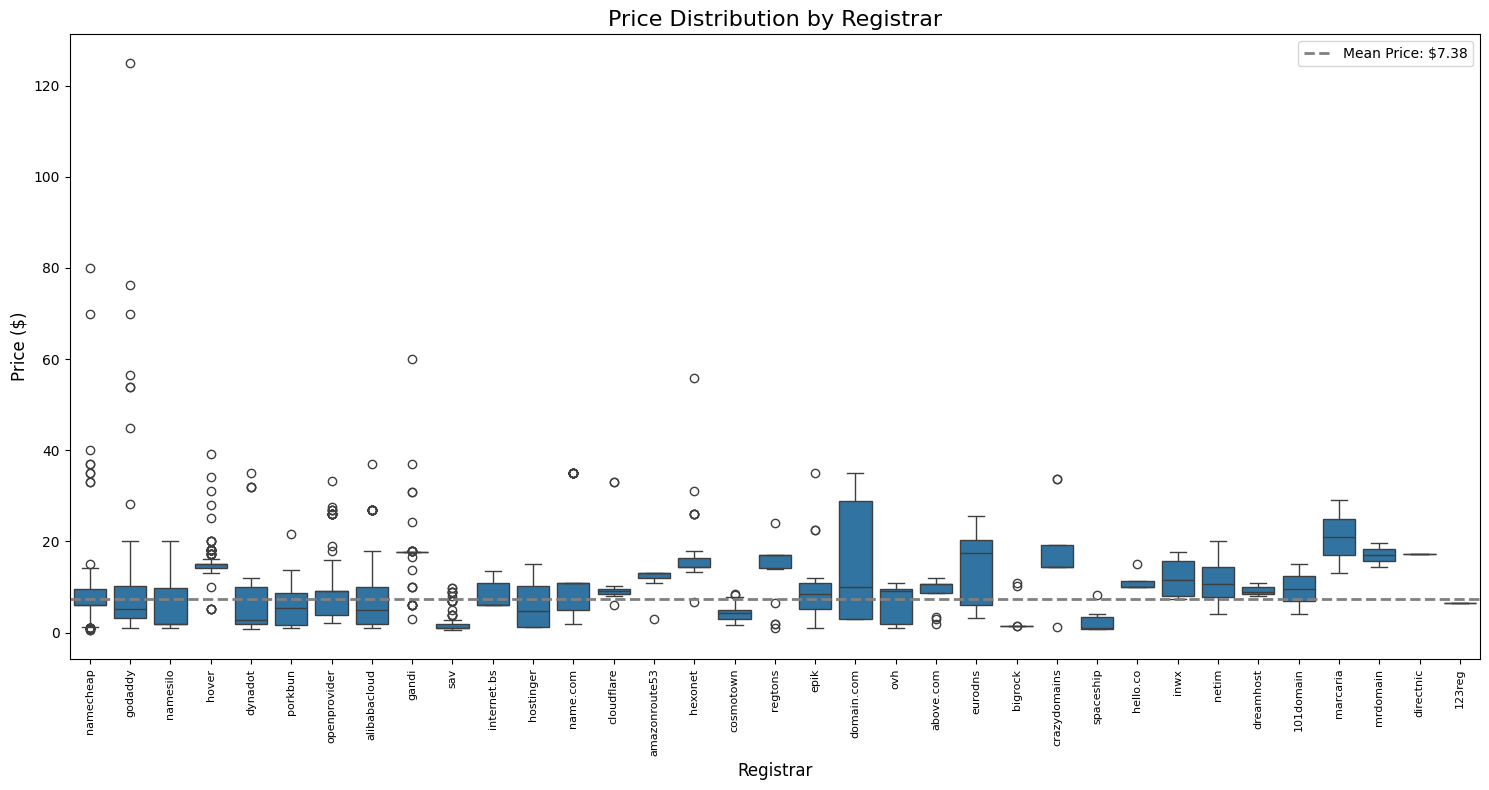

Graph saved to ./graphs/price/box-whisker-price-distribution-by-registrar.png


In [25]:
# Box whisker price distribution graph by registrar

registrar_popularity = whois_price_filtered["price-registrar"].value_counts()

whois_price_filtered["price-registrar"] = pd.Categorical(
    whois_price_filtered["price-registrar"],
    categories=registrar_popularity.index,
    ordered=True
)

overall_mean_price = whois_price_filtered["price"].mean()

plt.figure(figsize=(15, 8))

sns.boxplot(
    data=whois_price_filtered, 
    x="price-registrar", 
    y="price"
)

plt.axhline(y=overall_mean_price, color="gray", linestyle="--", linewidth=2, label=f"Mean Price: ${overall_mean_price:.2f}")

plt.title("Price Distribution by Registrar", fontsize=16)
plt.xlabel("Registrar", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.legend(loc="upper right", fontsize=10)

output_path = "./graphs/price/box-whisker-price-distribution-by-registrar.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Graph saved to {output_path}")

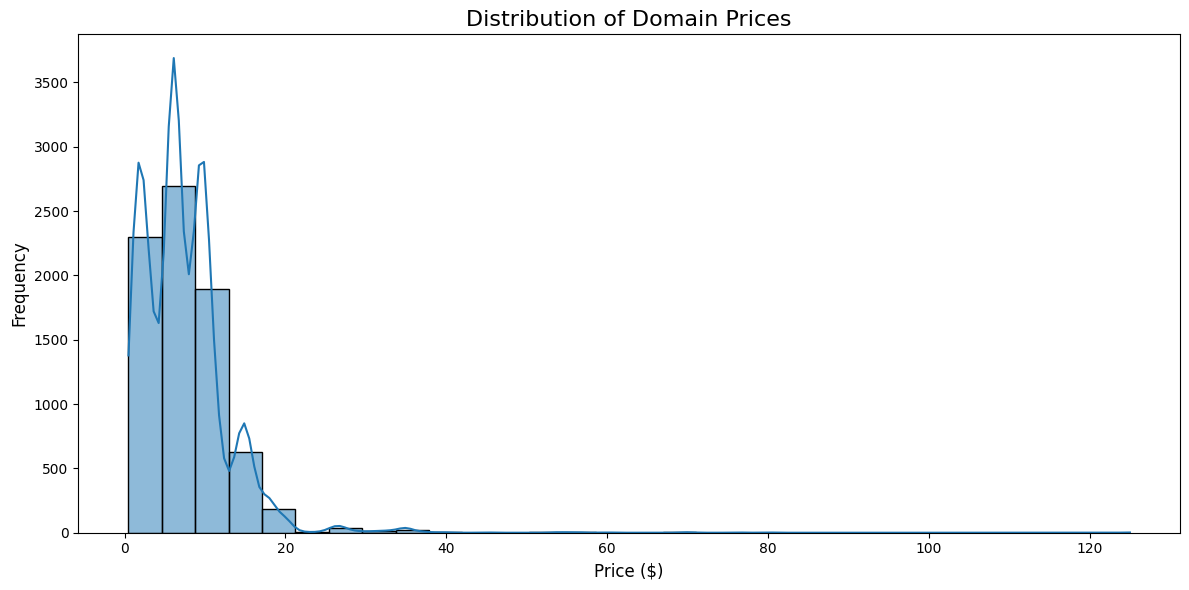

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(data=whois_price_filtered, x="price", bins=30, kde=True)
plt.title("Distribution of Domain Prices", fontsize=16)
plt.xlabel("Price ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
output_path = "./graphs/price/distribution-of-domain-prices.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()

/tmp/ipykernel_141153/1868728060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whois_price_filtered["created"] = pd.to_datetime(whois_price_filtered["created"])


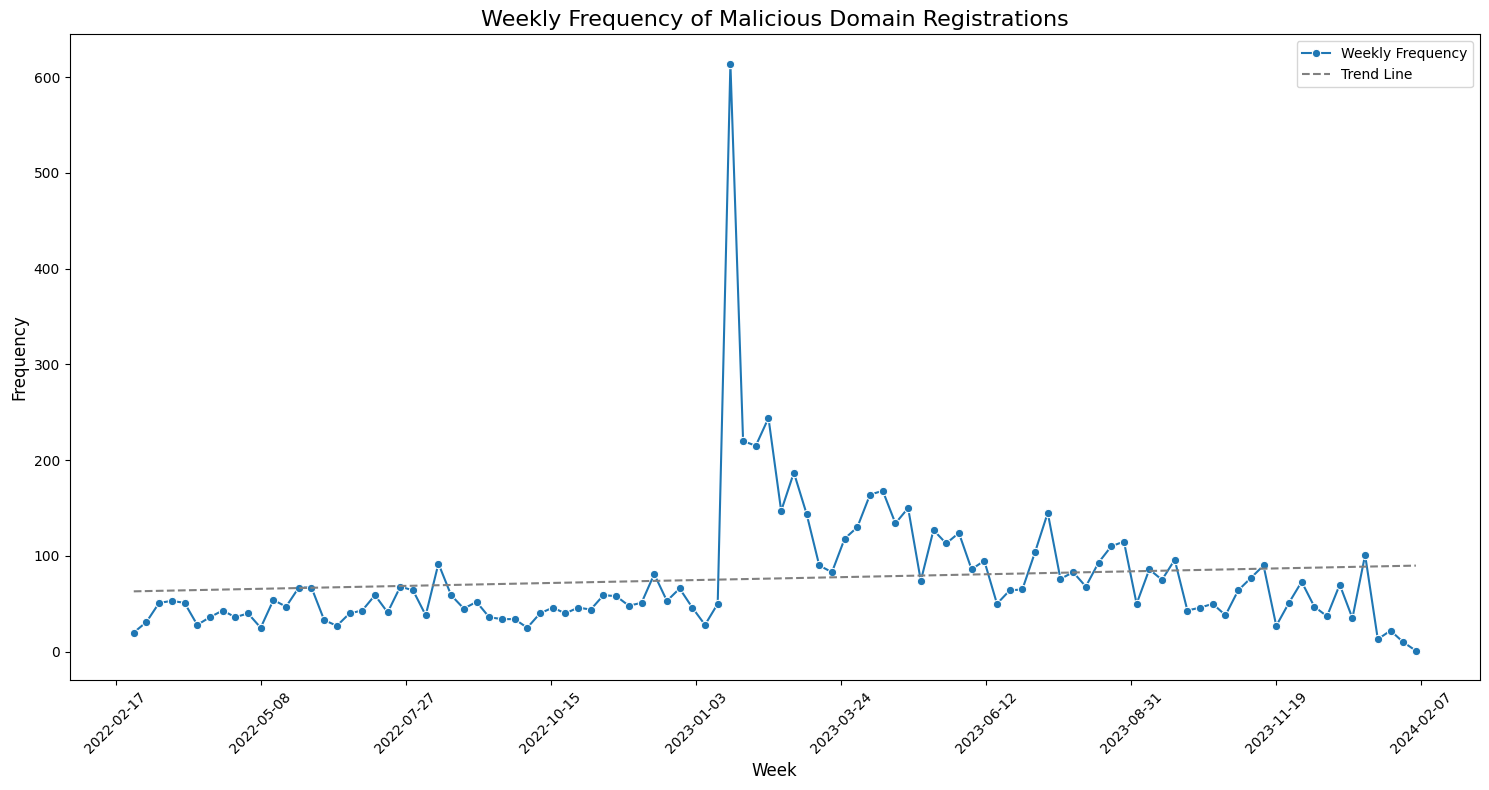

Graph saved to ./graphs/price/malicious-domain-weekly-frequency-with-trend-line.png


In [19]:
whois_price_filtered["created"] = pd.to_datetime(whois_price_filtered["created"])

malicious_trends = (
    whois_price_filtered
    .set_index("created")
    .resample('W')
    .size()
    .reset_index(name="frequency")
)

plt.figure(figsize=(15, 8))
sns.lineplot(data=malicious_trends, x="created", y="frequency", marker="o", label="Weekly Frequency")
malicious_trends["created_numeric"] = malicious_trends["created"].map(pd.Timestamp.toordinal)
z = np.polyfit(malicious_trends["created_numeric"], malicious_trends["frequency"], 1)
p = np.poly1d(z)

plt.plot(
    malicious_trends["created"],
    p(malicious_trends["created_numeric"]),
    color="gray",
    linestyle="--",
    label="Trend Line"
)

plt.title("Weekly Frequency of Malicious Domain Registrations", fontsize=16)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45, fontsize=10)
plt.legend()

output_path = "./graphs/price/malicious-domain-weekly-frequency-with-trend-line.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Graph saved to {output_path}")